In [8]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from optax import adam
import optax

from time import time 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import cat
from skimage.transform import resize

from chromatix.elements import PlaneWave, PhaseMask, FFLens, Propagate,GenericBeam, AmplitudeMask
from chromatix.functional import empty_field, plane_wave, transfer_propagate
from chromatix.utils import trainable
from typing import Sequence, Callable, Any

key = random.PRNGKey(42)

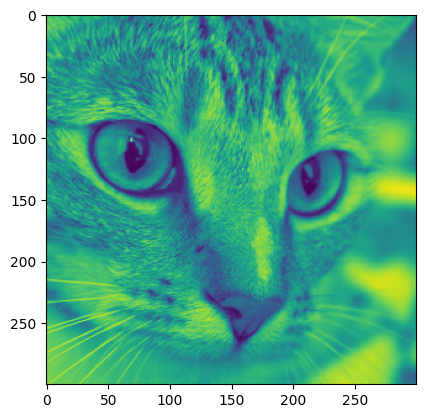

In [9]:
im = cat().mean(2)
im = im[:, 100:400]
plt.imshow(im)

In [10]:
init = random.uniform(key, shape=(1, im.shape[0], im.shape[1], 1), minval=0, maxval=1)
class CGH(nn.Module):
    @nn.compact
    def __call__(self, z):
        field = empty_field(shape=im.shape, dx=7.56, spectrum=0.66, spectral_density=1.0)
        field = plane_wave(field, kykx = (0, 0))
        field1 = AmplitudeMask(trainable(init), is_binary=True)(field)
        field2 = transfer_propagate(field1, z=z, n=1, N_pad=0)
        return field2

def loss_fn(params, data, z):
    approx = model.apply(params, z=z).intensity.squeeze() 
    loss = optax.cosine_distance(predictions=approx.reshape(-1),
                            targets=data.reshape(-1),
                            epsilon=1e-6).mean()
    return loss, {"loss": loss}

def step_fn(loss_fn, optimizer):
    def step(params, opt_state, *args):
        (_, metrics), grads = jax.value_and_grad(loss_fn, allow_int=True, has_aux=True)(
            params, *args
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, metrics
    return step


In [11]:
z = 13e4
model = CGH() 
params = model.init(key, z)
data = jnp.array(im)

In [12]:
start = time()
optimizer = adam(learning_rate=2)
opt_state = optimizer.init(params)
step = jax.jit(step_fn(loss_fn, optimizer))

max_iterations = 200
history = []
for iteration in range(max_iterations):
    params, opt_state, metrics = step(params, opt_state, data, z)
    history.append(metrics["loss"])
    if iteration % 20 == 0:
        print(f'processing {iteration}')
        approx1 = model.apply(params, z=z).intensity.squeeze() 
end = time()

print(f'Total time: {(end - start)}')
print(f'Time per iteration: {(end - start) / max_iterations}')

processing 0
processing 20
processing 40
processing 60
processing 80
processing 100
processing 120
processing 140
processing 160
processing 180
Total time: 1.0996160507202148
Time per iteration: 0.005498080253601074


0.08626485


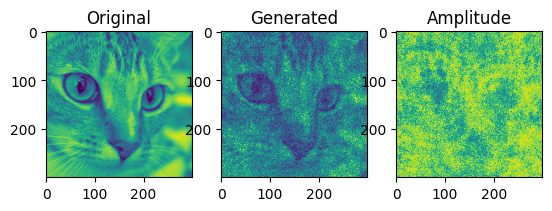

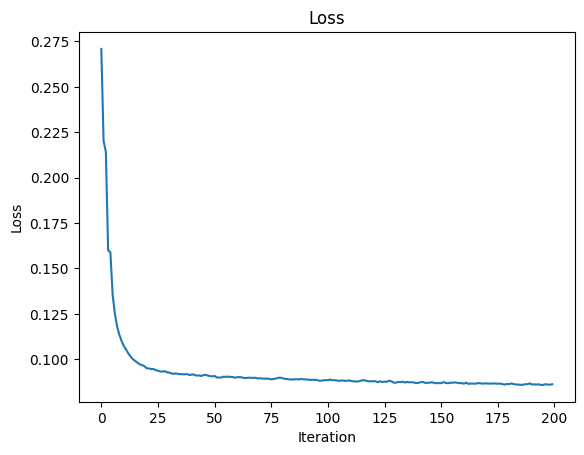

In [13]:
plt.subplot(1, 3, 1)
plt.imshow(data); plt.title('Original')
plt.subplot(1, 3, 2)
plt.imshow(approx1, vmax=np.percentile(approx1, 99)); plt.title('Generated')
plt.subplot(1, 3, 3)
amp = params['params']['AmplitudeMask_0']['amplitude_pixels'].squeeze()
plt.imshow(amp, vmax=np.percentile(amp, 99)); plt.title('Amplitude')
plt.figure(); plt.plot(history); plt.title('Loss'); plt.xlabel('Iteration'); plt.ylabel('Loss')
print(history[-1])

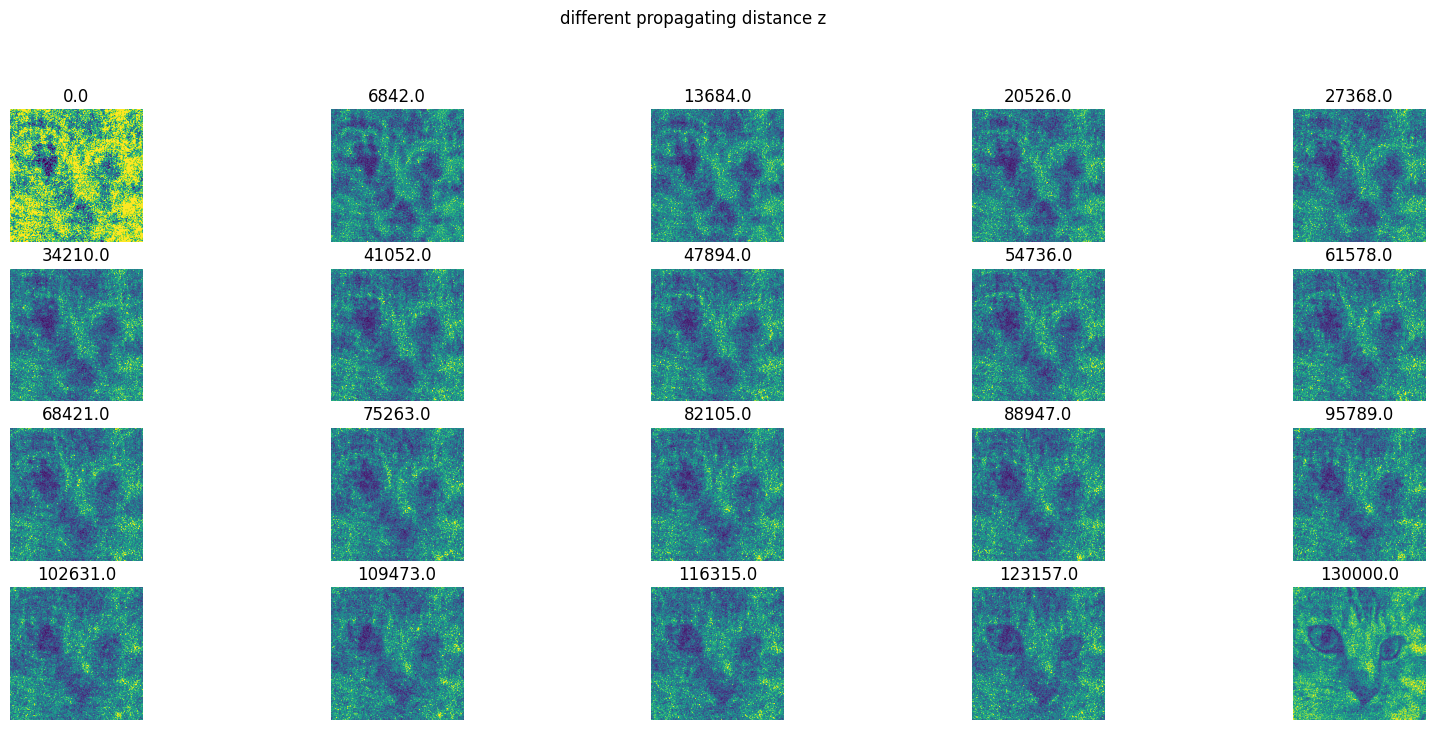

In [14]:
z_list = np.linspace(0., z, 20)[..., None, None, None]
images = model.apply(params, z=z_list).intensity.squeeze() 

plt.figure(figsize=(20,10))
plt.suptitle('different propagating distance z')

columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image, vmax=np.percentile(image, 95))
    plt.axis('off')    
    plt.title(f'{z_list[i].squeeze()//1}') 